<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br><h2>Tropical Cyclone Damage Assessment</h2><br>
Hurricane Maria - San Juan, Puerto Rico <br>
<h4>BCH-7815 | Business Challenge III </h4>
Team 03 MBAN<br>
Hult International Business School<br>
April 28, 2024 <br><br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h3> Introduction </h3>

Located in the northeastern Caribbean, Puerto Rico is part of the "hurricane belt." The island's location puts it directly in the path of tropical storms and hurricanes that form in the Atlantic Ocean. Hurricane Maria made landfall in Puerto Rico in September 2017, with sustained winds as high as 155 mph, which was barely below the Category 5 threshold. This natural event caused considerable damage to the island's infrastructure. The entire island was affected by uprooted trees, power lines pulled down, and residential and commercial roofs being destroyed. (Scott, 2018).  

In line with the above, we will analyze the Normalized Difference Vegetation Index (NDVI) to evaluate the health of vegetation pre and post storm. Moreover, the use deep learning model such as YOLO (You Only Look Once) for object detection and rapid analysis to assess infrastructure damage after hurricanes will be employed. This is crucial for efficient resource allocation and effective response in disasters' immediate aftermath. The integration of these technologies ensures that responses are more targeted and that resources are optimally used, which is crucial for areas like Puerto Rico that are frequently in the path of hurricanes. 

<h3>Top Three Actionable Insights </h3><br>

- <b> Housing Structure </b><br>
Housing structures in the Old San Juan, which is near the coastal line, are old century houses made of cobblestones or reinforced concrete with either flat roofs and or shingle roofings. The buildings were also erected near each other making them sturdier rather than stand-alone houses or buildings. While the most damaged areas by hurricane happened in rural areas where houses or buildings are more scattered, stand-alone and mostly made out of lightweight materials. 

   One way to lessen the effect of hurricanes on buildings, be it commercial or residential is by getting people to build more hurricane-proof buildings especially in the rural areas. Based on the outreach project initiated by the Federal Emergency Management Agency (FEMA) in conjunction with the Federal Alliance for Safe homes (FLASH), strong implementation of the use of materials based on ICC standards will surely make a lot of difference.  The houses, especially the older homes must ensure roof coverings are high wind-rated and attached properly regardless of the type (tiles, shingles, or metal). It is also highly recommended to install permanently-mounted hurricane shutters, strengthen the roof deck connection, and strengthen roof-to-wall connections by installing hurricane clips or straps. Lastly install a secondary water barrier and improve the anchorage of attached structures.<br><br>


- <b>Emergency / Evacuation Plan </b><br>
The government must identify shelters and broadcast them in advance, so that people can plan their route to safety. Each house must be equipped with a Basic-Disaster kit or emergency supplies like food, water, medicine, power supplies that will last the whole family for days while waiting for rescue (OSHA).  Although the aforementioned tactics are already in existence in different parts of the world, the thing here that sets them apart from other countries will be the constant education to the people of San Juan, Puerto Rico on the evacuation plan in case a hurricane hits the country again. <br><br>


- <b>Insurance Plan </b><br>
When Hurricane Maria hit San Juan, Puerto Rico, it uncovers that only a small percentage of the population’s homes were insured. Majority of the old homes which were passed down from generation to generation do not have insurance as well. The biggest take-away in this whole disaster was to get your homes insured as it wouldn’t be as costly as rebuilding your home or office buildings out of your own pockets (FEMA).



<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4> Libraries and packages </h4>

In [1]:
# supress warnings (be careful while using this)
import warnings
warnings.filterwarnings('ignore')

# import common GIS tools
import numpy                   as np
import xarray                  as xr
import matplotlib.pyplot       as plt
import rasterio.features
import rioxarray               as rio
from matplotlib.cm import RdYlGn, Reds

# import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load

# additional libraries
from datetime import date # date-related calculations

# GeoTiff images
import rasterio
from   osgeo import gdal

# data visualisation
from   matplotlib        import pyplot as plt
from   matplotlib.pyplot import figure
import matplotlib.image  as img
from   PIL               import Image

# model building
import ultralytics
from   ultralytics import YOLO
import labelme2yolo


# others
import os
import shutil
import zipfile

<h3> Part I. Pre- and Post-Event NDVI Analysis </h3>

Part I utilizes the <b> NDVI </b> to calculate changes in vegetation. This calculation is based on Sentinel-2 optical data and the goal is to identify areas where storms have damaged vegetation and to assess if there is significant damage to buildings in nearby regions. The process involves <b>defining the area of interest, the time period before and after the storm, the level of detail in the imagery (30 meters for Landstat), and filtering out the clouds </b>. Same procedures were followed in the three visualizations below, resulting in identical outputs.

<h4> Visualization 01 </h4>

<h4> Accessing Satellite Data </h4>

In [2]:
## Hurricane Maria - San Juan, Puerto Rico ##

## Defining the area of interest using latitude and longitude coordinates 
## at the center of the area we would like to observe

# Define the bounding box for the selected region 
min_lon = -66.19385887
min_lat =  18.27306794
max_lon = -66.069299
max_lat =  18.400288

# setting geographic boundary
bounds = (min_lon, min_lat, max_lon, max_lat)

# setting time window surrounding the storm landfall on September 20, 2017
time_window = "2017-04-08/2017-10-31"

# calculating days in time window
print(date(2017, 10, 31) - date(2017, 4, 8 ))

206 days, 0:00:00


In [3]:
## Using Planetary Computer's STAC catalog for items matching our query parameters above

# connecting to the planetary computer
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


# seaching for data
search = stac.search(collections = ["sentinel-2-l2a"],
                     bbox        = bounds,
                     datetime    = time_window)


# instantiating results list
items = list(search.get_all_items())


# summarizing results
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 63


In [4]:
## Setting the resolution to 10 meters per pixel, and then convert this to degrees per pixel for the
## latitude-longitude coordinate system

# pixel resolution for the final product
resolution = 10  # meters per pixel 


# scaling to degrees per pizel
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

In [5]:
## Use of Open Data Cube (ODC) for managing and analyzing geospatial data
## loading specific bands of data (like red, green, blue, near-infrared, and SCL)
## Filtering out clouds using the qa_pixel band and mapping at a resolution of 30 meters per pixel

xx = stac_load(
    items,
    bands      = ["red", "green", "blue", "nir", "SCL"],
    crs        = "EPSG:4326",                            # latitude-longitude
    resolution = scale,                                  # degrees
    chunks     = {"x": 2048, "y": 2048},
    dtype      = "uint16",
    patch_url  = pc.sign,
    bbox       = bounds
)

<h4> Viewing RGB (real color) images from the time series </h4>

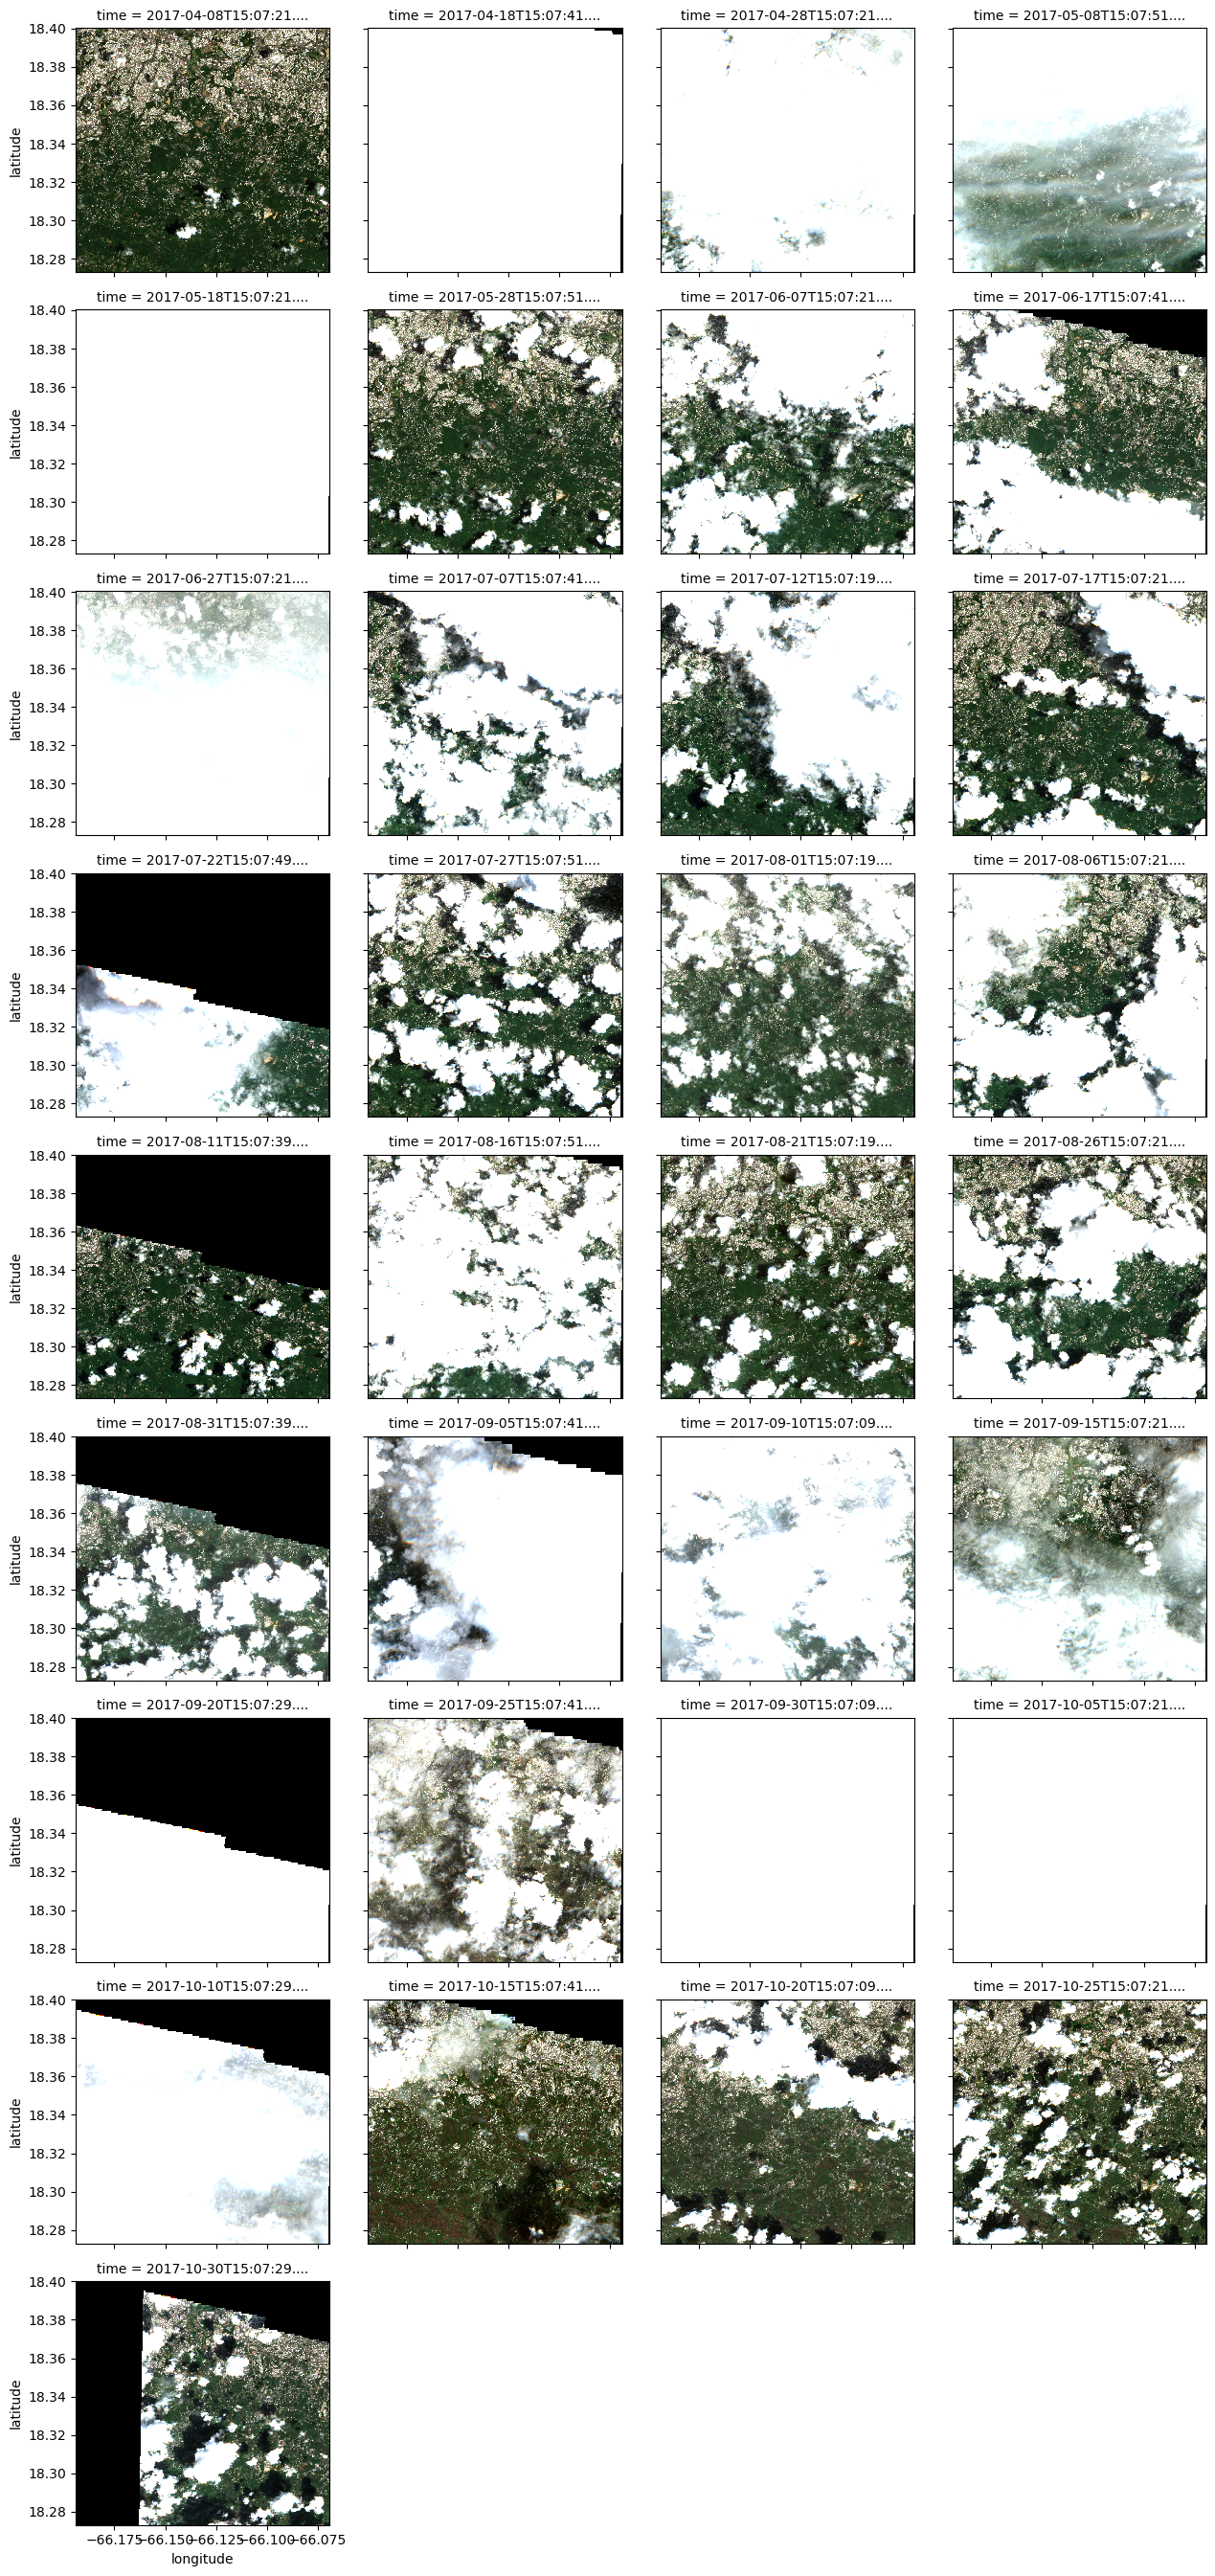

In [6]:
## Putting into comments since it will take some time to run

# # subsetting results for RGB
# plot_xx = xx[ ["red", "green", "blue"] ].to_array()


# # showing results 
# plot_xx.plot.imshow(col      = 'time', # time
#                     col_wrap = 4     , # four columns per row
#                     robust   = True  , 
#                     vmin     = 0     ,
#                     vmax     = 3000  )


# # rendering results
# plt.show()

This focuses on the lower part of San Juan where forests are prominent. It includes geographic area and time frame, relevant satellite data and various angles. Visualization aids in selecting clear satellite images, enabling assessment of the most damaged areas by comparing pre- and post-storm dates. It also helps in narrowing the time window to assess the extent of damage post-storm. A good pre- and post-storm image should have minimal cloud cover and a suitable angle for assessing NDVI changes.

In [7]:
# selecting a selected time slice to view a single RGB image and the cloud mask
time_slice = 29 # October 20, 2017 (post-storm)

In [195]:
# ## plotting an RGB real color image for a single date ##

# # setting plot size
# fig, ax = plt.subplots( figsize = (6, 10) )


# # preparing the plot
# xx.isel(time = time_slice)[ ["red", "green", "blue"] ].\
#     to_array().plot.imshow(robust = True,
#                            ax     = ax  ,
#                            vmin   = 0   ,
#                            vmax   = 3000)


# # titles and axis lables
# ax.set_title(label = f"RGB Color Results for Scene {time_slice}")
# ax.axis('off')


# # rendering results
# plt.show()

## This area of interest includes tropical forests and vegetation, some of which are located near Cupey and Caimito, 
## in the lower part of San Juan. These were significantly impacted as evidenced by the browning of vegetation. 
## According to NASA, nearly 60% of canopy trees in the region lost branches, snapped in half, or uprooted, with 
## trees that once had wide, spreading crowns now reduced to slender main trunks. Forests in Puerto Rico are now 
## approximately one-third shorter on average following Hurricane Maria (NASA, 2019).

<h4> Applying Cloud Filtering and Masking </h4>

In [9]:
# instantiating a colormap for SCL pixel classifications

scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
)

In [10]:
# function for color encoding
def colorize(xx, colormap):
    return xr.DataArray( colormap[xx.data],
                         coords = xx.coords,
                         dims   = (*xx.dims, "band") )

In [11]:
# filtering out water, etc.
filter_values = [0, 1, 3, 6, 8, 9, 10]

cloud_mask = ~xx.SCL.isin(filter_values) # this means not in filter_values

In [12]:
# appling cloud mask (filtering out clouds, cloud shadows, and water)

# storing as 16-bit integers
cleaned_data = xx.where(cloud_mask).astype("uint16")

In [191]:
# # converting SCL to RGB
# scl_rgba_clean = colorize(xx       = cleaned_data.isel(time = time_slice).SCL.compute(), 
#                           colormap = scl_colormap)


# # setting figure size
# plt.figure(figsize = (6, 10))
# plt.imshow(scl_rgba_clean)


# # titles and axis labels
# plt.title(label = "Cloud / Shadows / Water Mask (MAGENTA)")
# plt.axis('off')


# # rendering the plot
# plt.show()

## Code above creates a colormap for different land cover types based on Sentinel-2 Scene Classification Layer (SCL) 
## values. It then applies the colormap to the data, highlighting vegetation, bare ground, and water in distinct colors. 
## It filters out clouds, cloud shadows, and no data from the image represented by the magenta color, displaying the remaining land cover types in the area of interest.

<h4> Normalized Difference Vegetation Index (NDVI) </h4>

In [14]:
# preparing two time steps compare NDVI outputs
first_time  = 0  # April 08, 2017
second_time = 29 # October 20, 2017

In [194]:
# # Plots of NDVI at two different time slices
# # Clouds, Shadows and Water are masked

# # setting figure size
# fig, ax = plt.subplots(1, 2, figsize = (15, 10))


# # first image data
# ndvi_image = (cleaned_data.nir - cleaned_data.red) / (cleaned_data.nir + cleaned_data.red)
# ndvi_image.isel(time = first_time ).plot(ax = ax[0],
#                                          vmin = 0.0,
#                                          vmax = 0.8,
#                                          cmap = "RdYlGn")


# # second image data
# ndvi_image.isel(time = second_time).plot(ax = ax[1],
#                                          vmin = 0.0,
#                                          vmax = 0.8,
#                                          cmap = "RdYlGn")


# # axis labels
# ax[0].set_title(label = 'NDVI-Time #1'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
# ax[1].set_title(label = 'NDVI-Time #2'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)


# # rendering the plot
# plt.show()

## The figure is from April 08 and October 20, 2017. It creates plots of NDVI values for selected time window,
## masking out clouds, shadows, and no data. Values indicate the health and density of vegetation, with higher 
## values typically indicating healthier vegetation (dark green). Moreover, it illustrates how vegetation cover 
## changed post-storm, evident in the shift to lighter green, red, and orange shades, providing insights into the 
## sudden drop in NDVI after the storm.

<h4> NDVI Change Product </h4>

In [16]:
# function for calculating NDVI anomalies
def NDVI(dataset):
    return (dataset.nir - dataset.red) / (dataset.nir + dataset.red)

In [17]:
# running comparison
ndvi_clean = NDVI(cleaned_data)

# calculating difference
ndvi_pre     = ndvi_clean.isel(time = first_time)
ndvi_post    = ndvi_clean.isel(time = second_time)
ndvi_anomaly = ndvi_post - ndvi_pre


# all areas of water or clouds will be black
RdYlGn.set_bad('black',1.)


# reversing the colormap for reds
Reds_reverse = "Reds_r"

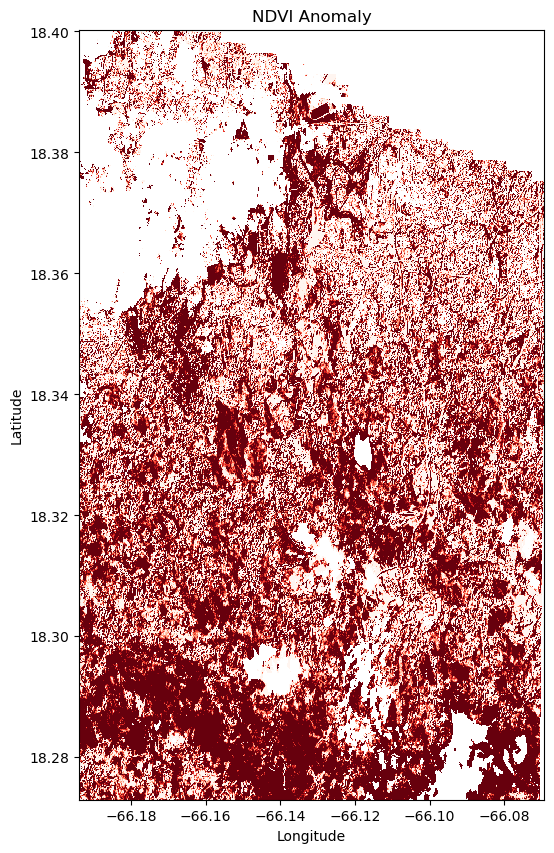

In [18]:
## plotting NDVI anomaly
plt.figure( figsize = (6,10) )
ndvi_anomaly.plot(vmin = -0.2, vmax=0.0, cmap = Reds_reverse, add_colorbar=False)


# titles and labels
plt.title (label  = "NDVI Anomaly")
plt.xlabel(xlabel = "Longitude")
plt.ylabel(ylabel = "Latitude")

# Save the current figure as a variable
ndvi_plot_01 = plt.gcf()

# Display the plot
plt.show()

<h4> Analysis (Visualization 01) </h4>

The <b>forest area</b> shows varying degrees of vegetation change after Hurricane María. The <b>darker red regions</b> indicate <b>severe damage</b>, likely due to high winds, tree fall, and extensive defoliation. Lighter red areas suggest moderate stress or partial vegetation loss, with potential for quicker recovery. Factors contributing to this varied impact include the storm's path and intensity, topography, forest composition, and proximity to urban infrastructure. These variations underscore the need for targeted recovery efforts, focused reforestation, and comprehensive disaster preparedness strategies in forested regions prone to hurricanes.

<h4> Visualization 02 </h4>

<h4> Accessing Satellite Data </h4>

In [69]:
# Define the bounding box for the selected region
min_lon = -66.19385887
min_lat =  18.27306794
max_lon = -66.08007533
max_lat =  18.48024350

# setting geographic boundary
bounds = (min_lon, min_lat, max_lon, max_lat)


# setting time window surrounding the storm landfall on September 20, 2017
time_window = "2017-04-08/2017-11-30"

# calculating days in time window
print(date(2017, 11, 1) - date(2017, 4, 1 ))

214 days, 0:00:00


In [70]:
## Using Planetary Computer's STAC catalog for items matching our query parameters above

# connecting to the planetary computer
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


# seaching for data
search = stac.search(collections = ["sentinel-2-l2a"],
                     bbox        = bounds,
                     datetime    = time_window)


# instantiating results list
items = list(search.get_all_items())


# summarizing results
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 73


In [71]:
## Setting the resolution to 10 meters per pixel, and then convert this to degrees per pixel for the
## latitude-longitude coordinate system

# pixel resolution for the final product
resolution = 10  # meters per pixel 


# scaling to degrees per pizel
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

In [72]:
## Use of Open Data Cube (ODC) for managing and analyzing geospatial data
## loading specific bands of data (like red, green, blue, near-infrared, and SCL)
## Filtering out clouds using the qa_pixel band and mapping at a resolution of 30 meters per pixel

xx = stac_load(
    items,
    bands      = ["red", "green", "blue", "nir", "SCL"],
    crs        = "EPSG:4326",                            # latitude-longitude
    resolution = scale,                                  # degrees
    chunks     = {"x": 2048, "y": 2048},
    dtype      = "uint16",
    patch_url  = pc.sign,
    bbox       = bounds
)

<h4> Viewing RGB (real color) images from the time series </h4>

In [192]:
## Putting into comments since it will take some time to run

# # subsetting results for RGB
# plot_xx = xx[ ["red", "green", "blue"] ].to_array()


# # showing results 
# plot_xx.plot.imshow(col      = 'time', # time
#                     col_wrap = 4     , # four columns per row
#                     robust   = True  , 
#                     vmin     = 0     ,
#                     vmax     = 3000  )


# # rendering results
# plt.show()

## This visual focuses in the middle part where houses are located near forested areas. Geographic area and 
## time frame, relevant satellite data, and various angles were displayed. Visualizations have more clouds
## and not a good angle, usually either cropped or not captured at all. Zooming in on the area was done to 
## assess the extent of damage. Same pre- and post-dates were chosen for consistency in assessing damage only 
## varying the coordinates.

In [74]:
# selecting a selected time slice to view a single RGB image and the cloud mask
time_slice = 30 # October 20, 2017 (post storm)

In [193]:
# ## plotting an RGB real color image for a single date ##

# # setting plot size
# fig, ax = plt.subplots( figsize = (6, 10) )


# # preparing the plot
# xx.isel(time = time_slice)[ ["red", "green", "blue"] ].\
#     to_array().plot.imshow(robust = True,
#                            ax     = ax  ,
#                            vmin   = 0   ,
#                            vmax   = 3000)


# # titles and axis lables
# ax.set_title(label = f"RGB Color Results for Scene {time_slice}")
# ax.axis('off')


# # rendering results
# plt.show()

## The highlighted area of interest includes tropical forests, vegetation, and surrounding suburbs, indicated by 
## white tones. Notably, there is observable browning of vegetation near forested regions, suburbs, and infrastructure 
## along the coastal areas. These findings align with Hosannah, N. et al. (2019), who noted a significant increase in 
## barren and pasture land cover post-storm, with forest cover being converted to bare soil (13%–41%) or pasture in 
## both forested areas and suburbs.

<h4> Applying Cloud Filtering and Masking </h4>

In [76]:
# filtering out water, etc.
filter_values = [0, 1, 3, 6, 8, 9, 10]

cloud_mask = ~xx.SCL.isin(filter_values) # this means not in filter_values

In [77]:
# appling cloud mask (filtering out clouds, cloud shadows, and water)

# storing as 16-bit integers
cleaned_data = xx.where(cloud_mask).astype("uint16")

In [115]:
## Putting into comments; same code as Viz 1

# # converting SCL to RGB
# scl_rgba_clean = colorize(xx       = cleaned_data.isel(time = time_slice).SCL.compute(), 
#                           colormap = scl_colormap)


# # setting figure size
# plt.figure(figsize = (6, 10))
# plt.imshow(scl_rgba_clean)


# # titles and axis labels
# plt.title(label = "Cloud / Shadows / Water Mask (MAGENTA)")
# plt.axis('off')


# # rendering the plot
# plt.show()

<h4> Normalized Difference Vegetation Index (NDVI) </h4>

In [79]:
# preparing two time steps compare NDVI outputs
first_time  = 0  # April 08, 2017
second_time = 30 # October 20, 2017

In [116]:
## Putting into comments; same code as Viz 1

# # Plots of NDVI at two different time slices
# # Clouds, Shadows and Water are masked

# # setting figure size
# fig, ax = plt.subplots(1, 2, figsize = (15, 10))


# # first image data
# ndvi_image = (cleaned_data.nir - cleaned_data.red) / (cleaned_data.nir + cleaned_data.red)
# ndvi_image.isel(time = first_time ).plot(ax = ax[0],
#                                          vmin = 0.0,
#                                          vmax = 0.8,
#                                          cmap = "RdYlGn")


# # second image data
# ndvi_image.isel(time = second_time).plot(ax = ax[1],
#                                          vmin = 0.0,
#                                          vmax = 0.8,
#                                          cmap = "RdYlGn")


# # axis labels
# ax[0].set_title(label = 'NDVI-Time #1'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
# ax[1].set_title(label = 'NDVI-Time #2'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)


# # rendering the plot
# plt.show()

<h4> NDVI Change Product </h4>

In [81]:
# running comparison
ndvi_clean = NDVI(cleaned_data)

# calculating difference
ndvi_pre     = ndvi_clean.isel(time = first_time)
ndvi_post    = ndvi_clean.isel(time = second_time)
ndvi_anomaly = ndvi_post - ndvi_pre


# all areas of water or clouds will be black
RdYlGn.set_bad('black',1.)


# reversing the colormap for reds
Reds_reverse = "Reds_r"

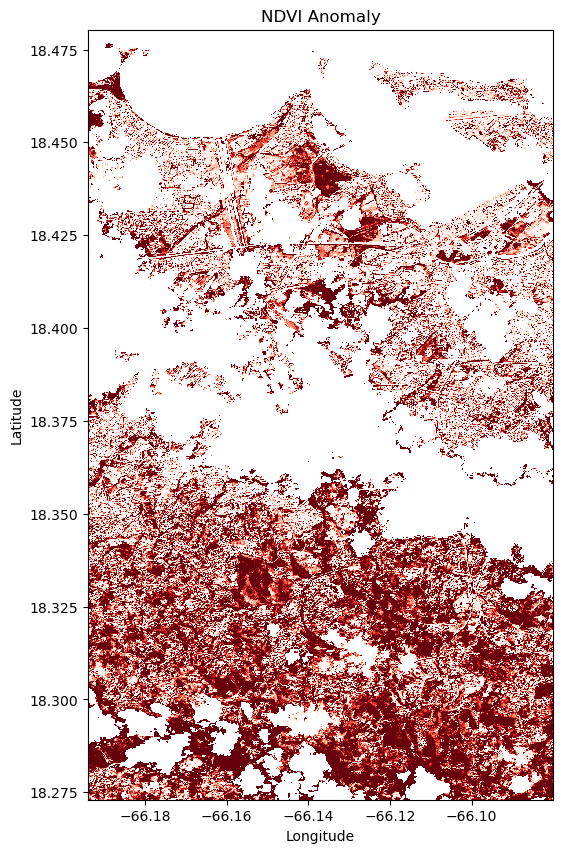

In [82]:
## plotting NDVI anomaly
plt.figure( figsize = (6,10) )
ndvi_anomaly.plot(vmin = -0.2, vmax=0.0, cmap = Reds_reverse, add_colorbar=False)


# titles and labels
plt.title (label  = "NDVI Anomaly")
plt.xlabel(xlabel = "Longitude")
plt.ylabel(ylabel = "Latitude")

# Save the current figure as a variable
ndvi_plot_02 = plt.gcf()

# Display the plot
plt.show()

<h4> Analysis (Visualization 02) </h4>

The dark red zones reflect acute vegetative destruction, hinting at the harsh conditions endured. Lighter reds and pinks signal less impacted areas that might recover more quickly, contingent on suitable soil and root health. White and pale zones likely represent non-vegetative or data-compromised areas and thus do not inform on vegetation status. The disparity in damage levels, potentially due to topography, land cover, and the storm's path, underscores the need for pinpointed restoration efforts and ongoing ecological tracking.

<h4> Visualization 03 </h4>

<h4> Accessing Satellite Data </h4>

In [83]:
# Define the bounding box for the selected region
min_lon = -66.1327369
min_lat =  18.4063942
max_lon = -66.0673603
max_lat =  18.4784524


# setting geographic boundary
bounds = (min_lon, min_lat, max_lon, max_lat)


# setting time window surrounding the storm landfall on September 20, 2017
time_window = "2017-04-01/2017-11-01"

# calculating days in time window
print(date(2017, 11, 1) - date(2017, 4, 1 ))

214 days, 0:00:00


In [84]:
## Using Planetary Computer's STAC catalog for items matching our query parameters above

# connecting to the planetary computer
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


# seaching for data
search = stac.search(collections = ["sentinel-2-l2a"],
                     bbox        = bounds,
                     datetime    = time_window)


# instantiating results list
items = list(search.get_all_items())


# summarizing results
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 45


In [85]:
## Setting the resolution to 10 meters per pixel, and then convert this to degrees per pixel for the
## latitude-longitude coordinate system

# pixel resolution for the final product
resolution = 10  # meters per pixel 


# scaling to degrees per pizel
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

In [86]:
## Use of Open Data Cube (ODC) for managing and analyzing geospatial data
## loading specific bands of data (like red, green, blue, near-infrared, and SCL)
## Filtering out clouds using the qa_pixel band and mapping at a resolution of 30 meters per pixel

xx = stac_load(
    items,
    bands      = ["red", "green", "blue", "nir", "SCL"],
    crs        = "EPSG:4326",                            # latitude-longitude
    resolution = scale,                                  # degrees
    chunks     = {"x": 2048, "y": 2048},
    dtype      = "uint16",
    patch_url  = pc.sign,
    bbox       = bounds
)

<h4> Viewing RGB (real color) images from the time series </h4>

In [189]:
## Putting into comments since it will take some time to run

# # subsetting results for RGB
# plot_xx = xx[ ["red", "green", "blue"] ].to_array()


# # showing results 
# plot_xx.plot.imshow(col      = 'time', # time
#                     col_wrap = 4     , # four columns per row
#                     robust   = True  , 
#                     vmin     = 0     ,
#                     vmax     = 3000  )


# # rendering results
# plt.show()

## This visualization targets an area in northern San Juan, Puerto Rico, featuring critical infrastructure near 
## coastal regions. It defines a specific geographical area and time range and collects pertinent satellite data.
## However, many visualizations are obscured by clouds, and some lack data entirely. To evaluate damage, we zoomed 
## into the area, maintaining consistent pre- and post-dates while varying coordinates to assess damage extent in
## this area.

In [88]:
# selecting a selected time slice to view a single RGB image and the cloud mask
time_slice = 21 # October 20, 2017 (post storm)

In [190]:
# ## plotting an RGB real color image for a single date ##

# # setting plot size
# fig, ax = plt.subplots( figsize = (6, 10) )


# # preparing the plot
# xx.isel(time = time_slice)[ ["red", "green", "blue"] ].\
#     to_array().plot.imshow(robust = True,
                           
#                            ax     = ax  ,
#                            vmin   = 0   ,
#                            vmax   = 3000)


# # titles and axis lables
# ax.set_title(label = f"RGB Color Results for Scene {time_slice}")
# ax.axis('off')


# # rendering results
# plt.show()

## It is evident that vegetation near coastal infrastructures has also shown signs of browning. This indicates 
## potential damage to houses and buildings. This image can help identify the specific types of buildings, 
## critical infrastructures, and areas most affected by the storm. Moreover, beach erosion and its significant 
## impact on coastal vulnerability can be assessed, as studied by Valentin & Muller (2020), who found an average 
## beach loss of 3 to 5 meters along the hurricane's path and up to 40 meters at certain beaches

<h4> Applying Cloud Filtering and Masking </h4>

In [89]:
# filtering out water, etc.
filter_values = [0, 1, 3, 6, 8, 9, 10]

cloud_mask = ~xx.SCL.isin(filter_values) # this means not in filter_values

In [91]:
# appling cloud mask (filtering out clouds, cloud shadows, and water)

# storing as 16-bit integers
cleaned_data = xx.where(cloud_mask).astype("uint16")

In [117]:
## Putting into comments; same code as Viz 1/2

# # converting SCL to RGB
# scl_rgba_clean = colorize(xx       = cleaned_data.isel(time = time_slice).SCL.compute(), 
#                           colormap = scl_colormap)


# # setting figure size
# plt.figure(figsize = (6, 10))
# plt.imshow(scl_rgba_clean)


# # titles and axis labels
# plt.title(label = "Cloud / Shadows / Water Mask (MAGENTA)")
# plt.axis('off')


# # rendering the plot
# plt.show()

Same as above for cloud filtering and masking

<h4> Normalized Difference Vegetation Index (NDVI) </h4>

In [93]:
# preparing two time steps compare NDVI outputs
first_time  = 0  # April 08, 2017
second_time = 21 # October 20, 2017

In [118]:
## Putting into comments; same code as Viz 1/2

# # Plots of NDVI at two different time slices
# # Clouds, Shadows and Water are masked

# # setting figure size
# fig, ax = plt.subplots(1, 2, figsize = (15, 10))


# # first image data
# ndvi_image = (cleaned_data.nir - cleaned_data.red) / (cleaned_data.nir + cleaned_data.red)
# ndvi_image.isel(time = first_time ).plot(ax = ax[0],
#                                          vmin = 0.0,
#                                          vmax = 0.8,
#                                          cmap = "RdYlGn")


# # second image data
# ndvi_image.isel(time = second_time).plot(ax = ax[1],
#                                          vmin = 0.0,
#                                          vmax = 0.8,
#                                          cmap = "RdYlGn")


# # axis labels
# ax[0].set_title(label = 'NDVI-Time #1'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
# ax[1].set_title(label = 'NDVI-Time #2'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)


# # rendering the plot
# plt.show()

## Using the same time window as before, this visualization generates plots of NDVI values while excluding clouds, 
## shadows, water, and dark areas near the coastal area. NDVI values indicate vegetation health and density, with 
## higher values suggesting healthier vegetation (dark green). The plots demonstrate changes in vegetation cover 
## following the storm near Guaynabo, Puerto Nuevo, and Catano, among others, highlighting shifts to lighter green, 
## red, yellow, and orange shades in forested, suburban, and coastal regions. These changes provide valuable insights 
## into the sudden decline in NDVI post-storm.

<h4> NDVI Change Product </h4>

In [95]:
# running comparison
ndvi_clean = NDVI(cleaned_data)

# calculating difference
ndvi_pre     = ndvi_clean.isel(time = first_time)
ndvi_post    = ndvi_clean.isel(time = second_time)
ndvi_anomaly = ndvi_post - ndvi_pre


# all areas of water or clouds will be black
RdYlGn.set_bad('black',1.)


# reversing the colormap for reds
Reds_reverse = "Reds_r"

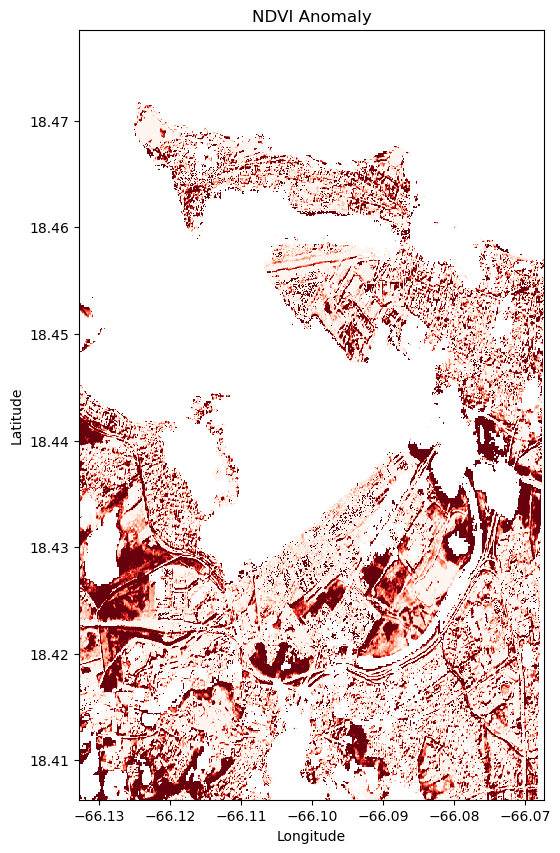

In [96]:
## plotting NDVI anomaly
plt.figure( figsize = (6,10) )
ndvi_anomaly.plot(vmin = -0.2, vmax=0.0, cmap = Reds_reverse, add_colorbar=False)


# titles and labels
plt.title (label  = "NDVI Anomaly")
plt.xlabel(xlabel = "Longitude")
plt.ylabel(ylabel = "Latitude")

# Save the current figure as a variable
ndvi_plot_03 = plt.gcf()

# Display the plot
plt.show()

<h4> Analysis (Visualization 03) </h4>

The visualization highlights striking contrasts in vegetation health with dark red areas indicating substantial damage, likely due to strong winds and rain near the coastal area for urban and suburban neighborhoods. Paler reds suggest areas of moderate impact, with prospects for a more rapid recovery. The irregular pattern of damage implies that factors like terrain variability and proximity to urban structures influenced the level of impact. The insights call for targeted reconstruction and strategic planning for similar future events.

<h3> Part II. Object Detection and Model Building </h3>

<h4> Generating Training and Testing Data along with the Configuration File </h4>

In [114]:
#!labelme2yolo --json_dir /path/to/labelme_json_dir/
!labelme2yolo --json_dir "./labelme_json_dir/"


Converting... ----------------------------------------   0% -:--:--
Converting... ----------------------------------------   0% -:--:--
Converting... ----------------------------------------   0% -:--:--
Converting... ----------------------------------------   0% -:--:--
Converting... ----------------------------------------   0% -:--:--
Converting... ----------------------------------------   0% -:--:--
Converting... ----------------------------------------   0% -:--:--
Converting... -- -------------------------------------   7% 0:00:01
Converting... ----- ----------------------------------  15% 0:00:02
Converting... -------- -------------------------------  21% 0:00:02
Converting... ---------- -----------------------------  26% 0:00:02
Converting... -------------- -------------------------  35% 0:00:01
Converting... ----------------- ----------------------  45% 0:00:01
Converting... -------------------- -------------------  52% 0:00:01
Converting... ----------------------- ---------

INFO:labelme2yolo:Searching label list from json files ...
INFO:labelme2yolo:Converting train set ...
INFO:labelme2yolo:Converting val set ...
INFO:labelme2yolo:Converting test set ...


<h4> Model Building and Model Training </h4>

In [112]:
#Loading the model
model = YOLO('yolov8n.pt')

# Display model information (optional)
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [119]:
# Train the model on the dataset for 50 epochs
results = model.train(data   = "./datasets/dataset.yaml", 
                      epochs = 50  ,
                      imgsz  = 512)

New https://pypi.org/project/ultralytics/8.2.4 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.47  Python-3.11.5 torch-2.2.2+cpu CPU (13th Gen Intel Core(TM) i7-1355U)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./datasets/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train642, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

train: Scanning C:\Users\joann\Documents\00 Hult 2023 2024\Spring 1 2024 Courses\Business Challenge III\From Chase\data


train: New cache created: C:\Users\joann\Documents\00 Hult 2023 2024\Spring 1 2024 Courses\Business Challenge III\From Chase\datasets\train.cache
WARNING  Box and segment counts should be equal, but got len(segments) = 680, len(boxes) = 15337. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


val: Scanning C:\Users\joann\Documents\00 Hult 2023 2024\Spring 1 2024 Courses\Business Challenge III\From Chase\datase


val: New cache created: C:\Users\joann\Documents\00 Hult 2023 2024\Spring 1 2024 Courses\Business Challenge III\From Chase\datasets\val.cache
WARNING  Box and segment counts should be equal, but got len(segments) = 163, len(boxes) = 3303. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs\detect\train642\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\train642
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      0.767     0.8557     0.9686        644        512: 100%|██████████| 26/26 [03:06<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.669      0.698      0.725      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.8003     0.8974     0.9787        432        512: 100%|██████████| 26/26 [03:01<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<0

                   all        104       3303      0.558      0.629      0.617      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.8119     0.9268     0.9783        480        512: 100%|██████████| 26/26 [02:56<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<0

                   all        104       3303      0.604      0.593      0.644       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.8567     0.9665     0.9887        452        512: 100%|██████████| 26/26 [03:07<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.513      0.571      0.558      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.8419     0.9802     0.9856        561        512: 100%|██████████| 26/26 [03:01<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<0

                   all        104       3303      0.561      0.638       0.63      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.8248     0.9408      0.984        520        512: 100%|██████████| 26/26 [03:02<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<0

                   all        104       3303      0.544      0.584      0.581      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.8336     0.9364     0.9926        496        512: 100%|██████████| 26/26 [03:01<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<0

                   all        104       3303      0.515      0.624      0.589      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.8467     0.9389     0.9958        384        512: 100%|██████████| 26/26 [02:57<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.529      0.557      0.557      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.8128     0.9111     0.9812        507        512: 100%|██████████| 26/26 [03:07<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<0

                   all        104       3303      0.636      0.592      0.645      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.8188     0.9017     0.9858        488        512: 100%|██████████| 26/26 [03:01<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<0

                   all        104       3303      0.523      0.576       0.58      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      0.803     0.8799     0.9849        498        512: 100%|██████████| 26/26 [02:58<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<0

                   all        104       3303      0.591      0.608      0.618      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.8049     0.8698     0.9763        462        512: 100%|██████████| 26/26 [03:00<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.593        0.6      0.606       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.8041     0.8691     0.9707        711        512: 100%|██████████| 26/26 [04:02<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:13<0

                   all        104       3303      0.601      0.628      0.642      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.8021     0.8743     0.9783        552        512: 100%|██████████| 26/26 [06:56<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:01<0

                   all        104       3303      0.591      0.576      0.615      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.8063      0.872     0.9773        480        512: 100%|██████████| 26/26 [07:18<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:58<0

                   all        104       3303      0.606      0.579      0.613      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.7982     0.8489     0.9758        399        512: 100%|██████████| 26/26 [06:19<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:51<0

                   all        104       3303      0.606      0.616      0.643       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.7868     0.8579     0.9729        570        512: 100%|██████████| 26/26 [06:53<00:00, 15.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:57<0

                   all        104       3303      0.556       0.65      0.626      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.7944     0.8612     0.9774        675        512: 100%|██████████| 26/26 [07:23<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:58<0

                   all        104       3303      0.637      0.599      0.652      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.7793     0.8171     0.9637        390        512: 100%|██████████| 26/26 [07:20<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:01<0

                   all        104       3303      0.592      0.641      0.647      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      0.801     0.8404     0.9773        423        512: 100%|██████████| 26/26 [06:50<00:00, 15.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:53<0

                   all        104       3303       0.61      0.606      0.637      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.7825     0.8126     0.9684        558        512: 100%|██████████| 26/26 [06:55<00:00, 15.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<0

                   all        104       3303      0.607      0.607       0.64      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.7592      0.804     0.9625        578        512: 100%|██████████| 26/26 [07:22<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:59<0

                   all        104       3303      0.578      0.638      0.637      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.7691     0.8126     0.9667        431        512: 100%|██████████| 26/26 [07:08<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:49<0

                   all        104       3303      0.641      0.643      0.673      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.7644     0.8024     0.9622        486        512: 100%|██████████| 26/26 [06:26<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:14<0

                   all        104       3303      0.612      0.653      0.663      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.7696     0.7892     0.9644        439        512: 100%|██████████| 26/26 [05:58<00:00, 13.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<0

                   all        104       3303      0.608       0.64      0.659      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.7569     0.7734      0.961        437        512: 100%|██████████| 26/26 [03:04<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:27<0

                   all        104       3303      0.624      0.642       0.68      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.7563     0.7627     0.9572        447        512: 100%|██████████| 26/26 [04:28<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<0

                   all        104       3303       0.59       0.64      0.662      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.7462     0.7556     0.9548        453        512: 100%|██████████| 26/26 [03:16<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<0

                   all        104       3303      0.634      0.616      0.652       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.7386     0.7703     0.9536        645        512: 100%|██████████| 26/26 [03:04<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<0

                   all        104       3303      0.588      0.644      0.653      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.7629     0.7736     0.9619        405        512: 100%|██████████| 26/26 [03:15<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.572      0.648      0.656      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.7468     0.7637     0.9547        518        512: 100%|██████████| 26/26 [03:02<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<0

                   all        104       3303      0.598      0.604      0.634      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.7256     0.7351     0.9463        506        512: 100%|██████████| 26/26 [04:15<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:45<0

                   all        104       3303      0.593      0.634      0.649      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.7376     0.7367     0.9475        761        512: 100%|██████████| 26/26 [07:07<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:10<0

                   all        104       3303      0.611      0.618      0.666      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      0.714     0.7322     0.9547        514        512: 100%|██████████| 26/26 [05:53<00:00, 13.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:40<0

                   all        104       3303      0.603      0.663      0.689      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G       0.73     0.7198     0.9482        285        512: 100%|██████████| 26/26 [04:00<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.571       0.68      0.675      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.7307     0.7204     0.9518        557        512: 100%|██████████| 26/26 [03:11<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.602      0.636      0.675      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.7208      0.713     0.9442        366        512: 100%|██████████| 26/26 [03:12<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.609      0.677      0.693      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      0.727     0.7049      0.935        435        512: 100%|██████████| 26/26 [03:10<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.583       0.66      0.679      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.7197     0.7007     0.9388        580        512: 100%|██████████| 26/26 [03:12<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<0

                   all        104       3303      0.665      0.633      0.693      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.7163     0.7032     0.9493        507        512: 100%|██████████| 26/26 [03:12<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.615      0.637      0.671      0.502


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.7144     0.6982     0.9432        341        512: 100%|██████████| 26/26 [03:14<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.649      0.642      0.689      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.7019     0.6887     0.9404        586        512: 100%|██████████| 26/26 [03:14<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.633      0.616      0.675      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.6983     0.6826     0.9365        426        512: 100%|██████████| 26/26 [03:11<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.657      0.642      0.696      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.7019     0.6883     0.9372        401        512: 100%|██████████| 26/26 [03:10<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.647      0.646      0.699      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.6965     0.6737     0.9377        576        512: 100%|██████████| 26/26 [03:09<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.643      0.635       0.69      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.6944     0.6655     0.9301        579        512: 100%|██████████| 26/26 [03:12<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.676      0.621      0.688      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.6815      0.667     0.9303        434        512: 100%|██████████| 26/26 [03:11<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.662      0.644      0.698      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.6859     0.6544     0.9294        551        512: 100%|██████████| 26/26 [03:10<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303       0.65      0.639      0.691      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.6795     0.6623     0.9283        624        512: 100%|██████████| 26/26 [03:11<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.673      0.628      0.694       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.6678     0.6472     0.9242        602        512: 100%|██████████| 26/26 [03:10<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<0

                   all        104       3303      0.662       0.63      0.698      0.531



50 epochs completed in 4.047 hours.
Optimizer stripped from runs\detect\train642\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train642\weights\best.pt, 6.2MB

Validating runs\detect\train642\weights\best.pt...
Ultralytics YOLOv8.1.47  Python-3.11.5 torch-2.2.2+cpu CPU (13th Gen Intel Core(TM) i7-1355U)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:33<0


                   all        104       3303      0.669      0.697      0.725      0.563
undamagedresidentialbuilding        104        132      0.592      0.483      0.518      0.349
damagedresidentialbuilding        104        552      0.648      0.736      0.767      0.592
undamagedcommercialbuilding        104        307      0.575      0.723      0.681      0.523
damagedcommercialbuilding        104       2312       0.86      0.844      0.934      0.787
Speed: 3.1ms preprocess, 145.3ms inference, 0.0ms loss, 28.3ms postprocess per image
Results saved to runs\detect\train642


<h4> Model Evaluation </h4>

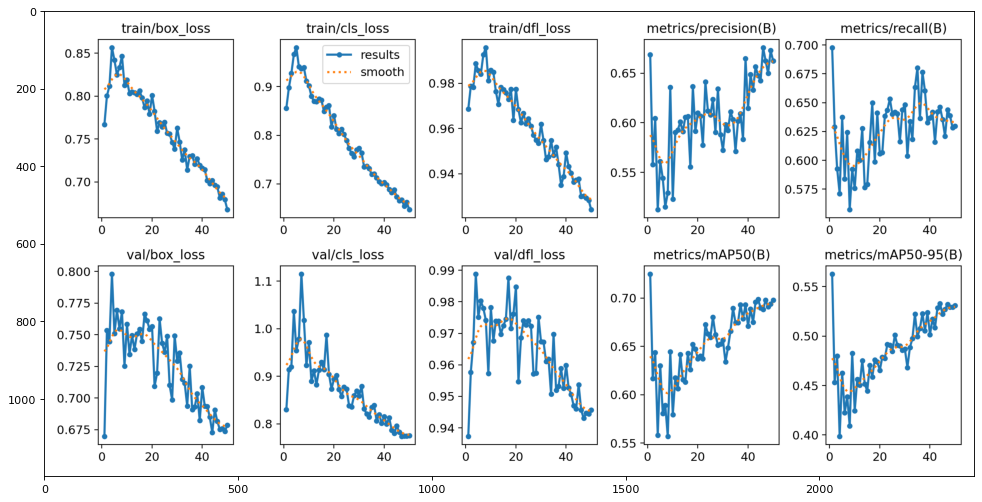

In [124]:
%matplotlib inline

figure(figsize=(15, 10), dpi=80)
# reading the image 
results = img.imread('./runs/detect/train642/results.png')

# displaying the image 
plt.imshow(results) 
plt.show()

<h3> Part III Model Analysis </h3>

<h4> Confusion Matrix </h4>

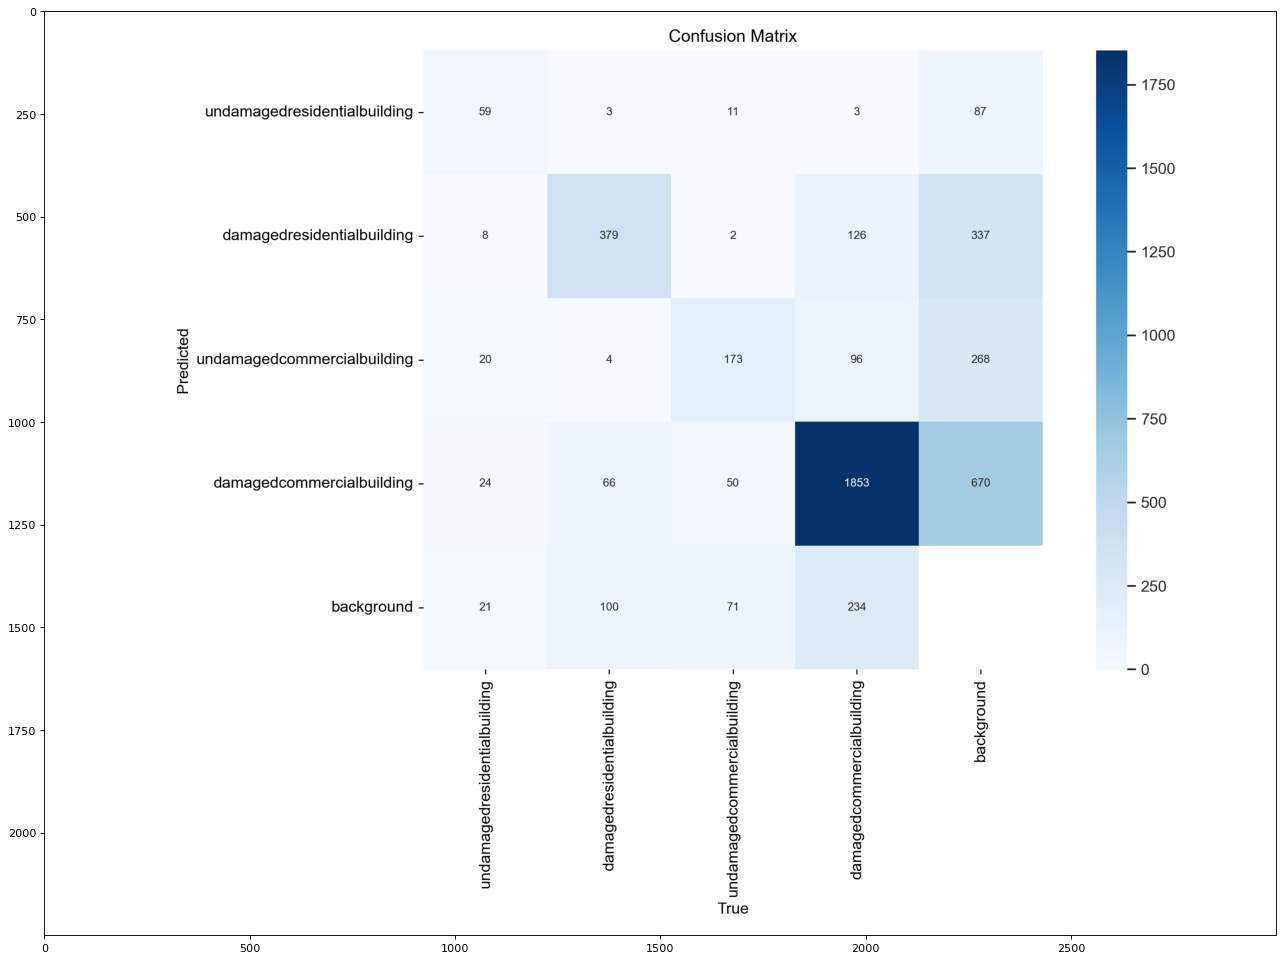

In [151]:
figure(figsize=(20,15), dpi=80)  

# reading the image 
cf = img.imread('./runs/detect/train642/confusion_matrix.png') 

# displaying the image 
plt.imshow(cf) 
plt.show()

<h4> Converting Confusion Matrix to One Class </h4>

<h4> Class 1 Undamaged residential buildings </h4>

In [184]:
# Confusion Matrix for Class 1 (2x2)
confusion_matrix_one = np.array([ [59, 104],
                                  [73,  4429] ] )

# Select rows and columns corresponding to class 1
class_index = 0
tn_1 = confusion_matrix_one[class_index, class_index]
fp_1 = confusion_matrix_one[:, class_index].sum() - tp_1
fn_1 = confusion_matrix_one[class_index, :].sum() - tp_1
tp_1 = confusion_matrix_one.sum() - tn_1 - fp_1 - fn_1

# Construct one-vs-all confusion matrix for class 1
class_one = np.array([[tp_1, fp_1],
                      [fn_1, tn_1]])

print("Confusion Matrix for Class 1 (undamaged residential building)")

# Unpacking the one-vs-all confusion matrix for Class 1
tn_1, fp_1, fn_1, tp_1 = class_one.ravel()

# Printing each result one-by-one
print(f"""
True Positives: {tp_1}
False Positives: {fp_1}
True Negatives: {tn_1}
False Negatives: {fn_1}
""")

# Calculate precision and recall for Class 1 (undamaged residential building)
precision_1 = tp_1 / (tp_1 + fp_1)
recall_1 = tp_1 / (tp_1 + fn_1)

print(f"Precision for Class 1: {precision_1:.4f}")
print(f"Recall for Class 1: {recall_1:.4f}")

Confusion Matrix for Class 1 (undamaged residential building)

True Positives: 59
False Positives: 73
True Negatives: 4429
False Negatives: 104

Precision for Class 1: 0.4470
Recall for Class 1: 0.3620


<h4> Class 2 Damaged residential buildings </h4>

In [183]:
# Confusion Matrix for Class 2 (2x2)
confusion_matrix_two = np.array([ [379, 473],
                                  [173,  3640] ] )

# Select rows and columns corresponding to class 2
class_index = 0
tn_2 = confusion_matrix_two[class_index, class_index]
fp_2 = confusion_matrix_two[:, class_index].sum() - tp_2
fn_2 = confusion_matrix_two[class_index, :].sum() - tp_2
tp_2 = confusion_matrix_two.sum() - tn_2 - fp_2 - fn_2

# Construct one-vs-all confusion matrix for class 2
class_two = np.array([[tp_2, fp_2],
                      [fn_2, tn_2]])

print("Confusion Matrix for Class 2 (damaged residential building)")

# Unpacking the one-vs-all confusion matrix for Class 2
tn_2, fp_2, fn_2, tp_2 = class_two.ravel()

# Printing each result one-by-one
print(f"""
True Positives: {tp_2}
False Positives: {fp_2}
True Negatives: {tn_2}
False Negatives: {fn_2}
""")

# Calculate precision and recall for Class 2 (damaged residential buildings)
precision_2 = tp_2 / (tp_2 + fp_2)
recall_2 = tp_2 / (tp_2 + fn_2)

print(f"Precision for Class 2: {precision_2:.4f}")
print(f"Recall for Class 2: {recall_2:.4f}")

Confusion Matrix for Class 2 (damaged residential building)

True Positives: 379
False Positives: 173
True Negatives: 3640
False Negatives: 473

Precision for Class 2: 0.6866
Recall for Class 2: 0.4448


<h4> Class 3 Undamaged commercial building </h4>

In [186]:
# Confusion Matrix for Class 3 (2x2)
confusion_matrix_three = np.array([ [173, 388],
                                    [134, 3970] ] )

# Select rows and columns corresponding to class 3
class_index = 0
tn_3 = confusion_matrix_three[class_index, class_index]
fp_3 = confusion_matrix_three[:, class_index].sum() - tp_3
fn_3 = confusion_matrix_three[class_index, :].sum() - tp_3
tp_3 = confusion_matrix_three.sum() - tn_3 - fp_3 - fn_3

# Construct one-vs-all confusion matrix for class 3
class_three = np.array([[tp_3, fp_3],
                      [fn_3, tn_3]])

print("Confusion Matrix for Class 3 (undamaged commercial building)")

# Unpacking the one-vs-all confusion matrix for Class 3
tn_3, fp_3, fn_3, tp_3 = class_three.ravel()

# Printing each result one-by-one
print(f"""
True Positives: {tp_3}
False Positives: {fp_3}
True Negatives: {tn_3}
False Negatives: {fn_3}
""")

# Calculate precision and recall for Class 3
precision_3 = tp_3 / (tp_3 + fp_3)
recall_3 = tp_3 / (tp_3 + fn_3)

print(f"Precision for Class 3: {precision_3:.4f}")
print(f"Recall for Class 3: {recall_3:.4f}")

Confusion Matrix for Class 3 (undamaged commercial building)

True Positives: 173
False Positives: 134
True Negatives: 3970
False Negatives: 388

Precision for Class 3: 0.5635
Recall for Class 3: 0.3084


<h4> Class 4 Damaged commercial building</h4>

In [187]:
# Confusion Matrix for Class 4 (2x2)
confusion_matrix_four = np.array([ [1853, 810],
                                    [459, 1543] ] )

# Select rows and columns corresponding to class 4
class_index = 0
tn_4 = confusion_matrix_four[class_index, class_index]
fp_4 = confusion_matrix_four[:, class_index].sum() - tp_4
fn_4 = confusion_matrix_four[class_index, :].sum() - tp_4
tp_4 = confusion_matrix_four.sum() - tn_4 - fp_4 - fn_4

# Construct one-vs-all confusion matrix for class 4
class_four = np.array([[tp_4, fp_4],
                      [fn_4, tn_4]])

print("Confusion Matrix for Class 4 (damaged commercial building)")

# Unpacking the one-vs-all confusion matrix for Class 4
tn_4, fp_4, fn_4, tp_4 = class_four.ravel()

# Printing each result one-by-one
print(f"""
True Positives: {tp_4}
False Positives: {fp_4}
True Negatives: {tn_4}
False Negatives: {fn_4}
""")

# Calculate precision and recall for Class 4
precision_4 = tp_4 / (tp_4 + fp_4)
recall_4 = tp_4 / (tp_4 + fn_4)

print(f"Precision for Class 2: {precision_4:.4f}")
print(f"Recall for Class 2: {recall_4:.4f}")

Confusion Matrix for Class 4 (damaged commercial building)

True Positives: 1853
False Positives: 459
True Negatives: 1543
False Negatives: 810

Precision for Class 2: 0.8015
Recall for Class 2: 0.6958


<h4> Confusion Matrix Analysis </h4>

<b>Undamaged vs. Damaged Commercial Buildings</b><br>
Between undamaged and damaged commercial buildings, the model shows a notable difference in performance. It exhibits higher precision and recall for identifying damaged commercial buildings compared to undamaged ones. This indicates that model is more adept at correctly classifying damaged commercial buildings while minimizing false positives and false negatives in this category.<br>

<b>Undamaged vs. Damaged Residential Buildings</b><br>
Similarly, when comparing undamaged and damaged residential buildings, the model demonstrates a similar trend. It performs better in correctly identifying damaged residential buildings, with higher precision and recall scores, suggesting that it is more reliable in distinguishing these structures from undamaged ones.<br>

Overall, the model shows a trend of higher performance in identifying damaged buildings across both residential and commercial categories, with varying levels of precision and recall for each class.

<h4> Conclusion </h4>

Our team labeled 60 images for both pre- and post-storm scenarios, achieving an mAP of around 0.50. Additionally, we leveraged Open Source Roboflow datasets, which use auto labeling, with the same images. We tried three different labeling approaches and concluded that manual labeling using polygons that outline the shape of the building without background elements yielded highest results compared to using fixed rectangles. Labeling commercial buildings is identifiable since we considered big parking spaces and flat roofings, while for residential buildings, it tends to appear smaller and with a ridge line in roofing.

Given more time, we could explore hybrid approaches of using polygons and fixed rectangles with overlapping, similar to how Roboflow labeled it. This is for further analysis, as our model performance improved after using open-source datasets from Roboflow.

Model results offer insights to NASA, Ernst and Young, and infrastructure sectors, enhancing disaster response using machine learning and deep learning with Sentinel-2 data, promoting resilient communities.

<h3> Steps your team would implement/improve if you were given three months to work on this project </h3>

Continuously improving the object detection model possibly by using more advanced models for accurate labeling and prediction. Also, considering the size of the buildings, among other features, may enhance its ability to classify damaged and undamaged buildings accurately, leading to better results. Additionally, QGIS offers tools for spatial analysis and feature extraction, allowing for further refinement of object detection algorithms based on building characteristics such as size, shape, and spatial arrangement. Applying advanced pre-processing techniques (sharpening, noise reduction) to improve image clarity. Finally, employing a hybrid approach in manual labeling and using auto-labeling tools to compare results could be beneficial.

<h3> Part IV. Feedback to EY </h3>

The team faced several challenges in analyzing images, including the need to enhance image quality for easier annotation and labeling. Blurred or hard-to-identify images pose challenges. Additionally, differences in frame area and angle between pre- and post-images make comparisons difficult. For example, a small building in the pre-image might appear larger in the post-image, potentially affecting model accuracy in labeling buildings correctly. Quality differences, such as clear skies in the pre-image versus cloud cover or shadows in the post-image, limit the selection of suitable images for the model. <br><br>
Overlaying building footprints in QGIS can also provide valuable spatial context for object detection. By integrating building footprint data with satellite imagery or other geospatial datasets, it can visualize the distribution of buildings within an area.

<h3> References </h3>

Bane, B. (2021, September 22). Artificial Intelligence brings better hurricane predictions. Pacific Northwest National Laboratory. https://www.pnnl.gov/news-media/artificial-intelligence-brings-better-hurricane-predictions 

Find Codes. (n.d.). Codes.iccsafe.org. https://codes.iccsafe.org/codes/puerto-rico

Grabmeier, J. (2022, October 6). New machine learning model can provide more accurate assessments of hurricane damage for responders. The Ohio State University. https://techxplore.com/news/2022-10-machine-accurate-hurricane.html 

Hosannah, N., Ramamurthy, P., Marti, J., Munoz, J., & González, J. E. (2021). Impacts of Hurricane Maria on land and convection
modification over Puerto Rico. Journal of Geophysical Research: Atmospheres, 126, e2020JD032493. https://doi. org/10.1029/2020JD032493

Hurricane Preparedness and Response - Preparedness | Occupational Safety and Health Administration. (n.d.). www.osha.gov. https://www.osha.gov/hurricane/preparedness

Kundu, R. (2022, August 3). Image Processing: Techniques, Types & Applications [2023]. https://www.v7labs.com/blog/image-processing-guide 

Maayan, G. (2023, September 12). Complete Guide to Image Labeling for Computer Vision. Comet. https://www.comet.com/site/blog/complete-guide-to-image-labeling-for-computer-vision/ 

Microsoft Planetary Computer. Landsat Collection 2 Level-2. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

Microsoft Planetary Computer. Sentinel-2 Level-2A. https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a

NASA (July 2019). NASA Surveys Hurricane Damage to Puerto Rico's Forests (Data Viz Version). https://svs.gsfc.nasa.gov/4735/

PBS Org (March, 2019). Hurricane Maria Devastated Puerto Rico’s Forests at an Unprecedented Rate. https://www.pbs.org/wgbh/nova/article/hurricane-maria-devastated-puerto-ricos-forests-at-an-unprecedented-rate/

Pérez Valentín, J. M., & Müller, M. F.(2020). Impact of Hurricane Maria onbeach erosion in Puerto Rico: Remotesensing and causal inference.Geophysical Research Letters,47,e2020GL087306. https://doi.org/10.1029/2020GL087306Received 

Protective Actions Research. (2024). Fema.gov. https://community.fema.gov/ProtectiveActions/s/article/Hurricane-Review-Your-Insurance

Roboflow User (um). tes1 Image Dataset. https://universe.roboflow.com/um-w3o1a/tes1-mjea9/dataset/3. Retrieved 24Apr2023

Scott, M. (2018, August 1). Hurricane Maria’s devastation of Puerto Rico. https://www.climate.gov/news-features/understanding-climate/hurricane-marias-devastation-puerto-rico 

Shorten, C., Khoshgoftaar, T.M. (2019, July 6). A survey on Image Data Augmentation for Deep Learning. J Big Data 6, 60 (2019). https://doi.org/10.1186/s40537-019-0197-0 

USGS. Landsat Collection 2 Quality Assessment Bands. https://www.usgs.gov/landsat-missions/landsat-collection-2-quality-assessment-bands